Netflix Churn imrovement based on recomendations system for movies/series

In [1]:
import numpy as np
import pandas as pd
import datetime as dt


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go


import string
string.punctuation
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

import warnings;warnings.filterwarnings('ignore')
import warnings;warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df= pd.read_csv("/content/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

In [3]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.shape

(7787, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [6]:
print(f"duplicated values in the dataset: {df.duplicated().sum()}")

duplicated values in the dataset: 0


In [7]:
#checking the nan values
print("Null values in each of the variable\n")
print(df.isnull().sum())

print("Percentage of null values in each variable: \n")
null_count_by_variable = df.isnull().sum()/len(df)
print(f"{null_count_by_variable*100}%")

Null values in each of the variable

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64
Percentage of null values in each variable: 

show_id          0.000000
type             0.000000
title            0.000000
director        30.679337
cast             9.220496
country          6.510851
date_added       0.128419
release_year     0.000000
rating           0.089893
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64%


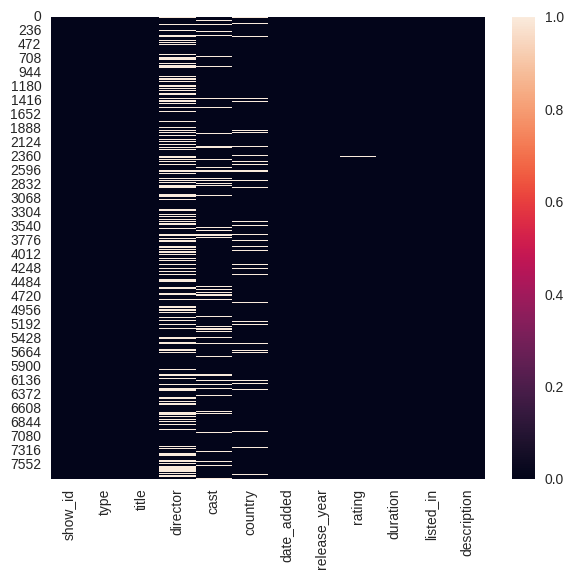

In [8]:
plt.figure(figsize=(7,6))
sns.heatmap(df.isnull(),cbar=True)
plt.show()

Understanding the columns and variables

In [9]:
# Dataset Columns
print(f"All columns:\n{df.columns.to_list()}")

All columns:
['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,7787,7787,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7787,2,Movie,5377,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,7787,7787,3%,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,5398,4049,"Raúl Campos, Jan Suter",18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,7069,6831,David Attenborough,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,7280,681,United States,2555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,7777,1565,"January 1, 2020",118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,7787.0,NaN,NaN,NaN,2013.93258,8.757395,1925.0,2013.0,2017.0,2018.0,2021.0
rating,7780,14,TV-MA,2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,7787,216,1 Season,1608,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.nunique()

show_id         7787
type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

In [12]:
#handeling null values
df["date_added"].value_counts()

date_added
January 1, 2020      118
November 1, 2019      94
December 31, 2019     76
March 1, 2018         76
October 1, 2018       72
                    ... 
October 12, 2014       1
March 22, 2020         1
March 31, 2013         1
December 12, 2019      1
January 11, 2020       1
Name: count, Length: 1565, dtype: int64

In [13]:
df['rating'].value_counts()

rating
TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: count, dtype: int64

In [14]:
df[['director','cast']]=df[['director','cast']].fillna("Unknown")
df['country']=df['country'].fillna(df['country'].mode()[0])
df.dropna(axis=0, inplace=True)

In [15]:
print(df.isna().sum())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [16]:
df_new= df.copy()

In [17]:
# fixing directors column

dir_constraint=df['director'].apply(lambda x: str(x).split(', ')).tolist()
df1 = pd.DataFrame(dir_constraint, index = df['title'])
df1 = df1.stack()
df1 = pd.DataFrame(df1.reset_index())
df1.rename(columns={0:'Directors'},inplace=True)
df1 = df1.drop(['level_1'],axis=1)
df1.sample(5)

,title,Directors
2363,Fishtronaut: The Movie,Kiko Mistrorigo
4695,My Perfect Romance,Justin G. Dyck
8081,Vir Das: For India,Vir Das
1807,Deewana Main Deewana,K.C. Bokadia
3939,Liss Pereira: Reteniendo líquidos,Fernando Ayllón


In [18]:
#now cast

cast_constraint=df['cast'].apply(lambda x: str(x).split(', ')).tolist()
df2 = pd.DataFrame(cast_constraint, index = df['title'])
df2 = df2.stack()
df2 = pd.DataFrame(df2.reset_index())
df2.rename(columns={0:'Actors'},inplace=True)
df2 = df2.drop(['level_1'],axis=1)
df2.sample(5)

,title,Actors
34933,Pokémon the Movie: I Choose You!,Ikue Otani
36448,Ram Jaane,Pankaj Kapur
32069,Nightmare High,Da-Ye Kim
44475,The Car: Road to Revenge,Burt Grinstead
45203,The Devil Punisher,Amanda Chou


In [19]:
listed_constraint=df['listed_in'].apply(lambda x: str(x).split(', ')).tolist()
df3 = pd.DataFrame(listed_constraint, index = df['title'])
df3 = df3.stack()
df3 = pd.DataFrame(df3.reset_index())
df3.rename(columns={0:'Genre'},inplace=True)
df3 = df3.drop(['level_1'],axis=1)
df3.sample(5)

,title,Genre
11087,Railroad Tigers,Comedies
8098,Lorai: Play to Live,Sports Movies
912,All Hail King Julien,TV Comedies
12153,She's the One,Dramas
15069,The Sound of Your Heart,International TV Shows


In [20]:
country_constraint=df['country'].apply(lambda x: str(x).split(', ')).tolist()
df4 = pd.DataFrame(country_constraint, index = df['title'])
df4 = df4.stack()
df4 = pd.DataFrame(df4.reset_index())
df4.rename(columns={0:'Country'},inplace=True)
df4 = df4.drop(['level_1'],axis=1)
df4.sample(5)

,title,Country
4131,Kiss the Girls,United States
4006,Kanika,India
1915,Dabbe 5: Zehr-i Cin,Turkey
6014,Private Life,United States
2953,Girl's Revenge,Taiwan


Merging all the unested data

In [21]:
df5 = df2.merge(df1,on=['title'],how='inner')
df6 = df5.merge(df3,on=['title'],how='inner')
#country with (director and cast)]
df7 = df6.merge(df4,on=['title'],how='inner')
df7.head()

,title,Actors,Directors,Genre,Country
0,3%,João Miguel,Unknown,International TV Shows,Brazil
1,3%,João Miguel,Unknown,TV Dramas,Brazil
2,3%,João Miguel,Unknown,TV Sci-Fi & Fantasy,Brazil
3,3%,Bianca Comparato,Unknown,International TV Shows,Brazil
4,3%,Bianca Comparato,Unknown,TV Dramas,Brazil


In [22]:
df = df7.merge(df[['type', 'title', 'date_added', 'release_year', 'rating', 'duration','description']],on=['title'],how='left')
df.head()

,title,Actors,Directors,Genre,Country,type,date_added,release_year,rating,duration,description
0,3%,João Miguel,Unknown,International TV Shows,Brazil,TV Show,"August 14, 2020",2020,TV-MA,4 Seasons,In a future where the elite inhabit an island ...
1,3%,João Miguel,Unknown,TV Dramas,Brazil,TV Show,"August 14, 2020",2020,TV-MA,4 Seasons,In a future where the elite inhabit an island ...
2,3%,João Miguel,Unknown,TV Sci-Fi & Fantasy,Brazil,TV Show,"August 14, 2020",2020,TV-MA,4 Seasons,In a future where the elite inhabit an island ...
3,3%,Bianca Comparato,Unknown,International TV Shows,Brazil,TV Show,"August 14, 2020",2020,TV-MA,4 Seasons,In a future where the elite inhabit an island ...
4,3%,Bianca Comparato,Unknown,TV Dramas,Brazil,TV Show,"August 14, 2020",2020,TV-MA,4 Seasons,In a future where the elite inhabit an island ...


Typecasting of attributes

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175807 entries, 0 to 175806
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         175807 non-null  object
 1   Actors        175807 non-null  object
 2   Directors     175807 non-null  object
 3   Genre         175807 non-null  object
 4   Country       175807 non-null  object
 5   type          175807 non-null  object
 6   date_added    175807 non-null  object
 7   release_year  175807 non-null  int64 
 8   rating        175807 non-null  object
 9   duration      175807 non-null  object
 10  description   175807 non-null  object
dtypes: int64(1), object(10)
memory usage: 14.8+ MB


In [24]:
# Convert the 'date_added' column to datetime, with errors='coerce'
df['date_added'] = pd.to_datetime(df['date_added'], format="%B %d, %Y", errors='coerce')

# Check for NaT values
na_values = df[df['date_added'].isna()]['date_added']

# Print the NaT values
print("NaT values:")
print(na_values)


NaT values:
6199     NaT
6200     NaT
6201     NaT
6202     NaT
6203     NaT
          ..
169942   NaT
169943   NaT
169944   NaT
172736   NaT
172737   NaT
Name: date_added, Length: 1588, dtype: datetime64[ns]


In [25]:
df.dropna(subset=['date_added'], inplace=True)
print("Shape of DataFrame after removing rows with NaT values:", df.shape)

Shape of DataFrame after removing rows with NaT values: (174219, 11)


In [26]:
df['duration'] = df['duration'].replace('Seasons', 'Season', regex=True)
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)
df['duration'] = df['duration'].fillna(0).astype(int)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174219 entries, 0 to 175806
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         174219 non-null  object        
 1   Actors        174219 non-null  object        
 2   Directors     174219 non-null  object        
 3   Genre         174219 non-null  object        
 4   Country       174219 non-null  object        
 5   type          174219 non-null  object        
 6   date_added    174219 non-null  datetime64[ns]
 7   release_year  174219 non-null  int64         
 8   rating        174219 non-null  object        
 9   duration      174219 non-null  int64         
 10  description   174219 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 16.0+ MB


Binning of rating column

In [28]:
rating_map = {'TV-MA':'Adult Content',
              'R':'Adult Content',
              'PG-13':'Teen Content',
              'TV-14':'Teen Content',
              'TV-PG':'Children Content',
              'NR':'Not Rated',
              'TV-G':'Children Content',
              'TV-Y':'Family-friendly Content',
              'TV-Y7':'Family-friendly Content',
              'PG':'Children Content',
              'G':'Children Content',
              'NC-17':'Adult Content',
              'TV-Y7-FV':'Family-friendly Content',
              'UR':'Not Rated'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adult Content', 'Teen Content', 'Children Content', 'Not Rated',
       'Family-friendly Content'], dtype=object)

In [29]:
df.head(5)

,title,Actors,Directors,Genre,Country,type,date_added,release_year,rating,duration,description
0,3%,João Miguel,Unknown,International TV Shows,Brazil,TV Show,2020-08-14,2020,Adult Content,4,In a future where the elite inhabit an island ...
1,3%,João Miguel,Unknown,TV Dramas,Brazil,TV Show,2020-08-14,2020,Adult Content,4,In a future where the elite inhabit an island ...
2,3%,João Miguel,Unknown,TV Sci-Fi & Fantasy,Brazil,TV Show,2020-08-14,2020,Adult Content,4,In a future where the elite inhabit an island ...
3,3%,Bianca Comparato,Unknown,International TV Shows,Brazil,TV Show,2020-08-14,2020,Adult Content,4,In a future where the elite inhabit an island ...
4,3%,Bianca Comparato,Unknown,TV Dramas,Brazil,TV Show,2020-08-14,2020,Adult Content,4,In a future where the elite inhabit an island ...


In [30]:
#seperating movies and series

df_movies= df[df['type']== 'Movie']
df_tvshows= df[df['type']== 'TV Show']

print(df_movies.shape, df_tvshows.shape)

(126079, 11) (48140, 11)


In [31]:
labels = ['TV Show', 'Movie']
values = [df.type.value_counts()[1], df.type.value_counts()[0]]

colors = ['#ffd700', '#008000']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6)])

fig.update_layout(
    title_text='Content Watched on Netflix',
    title_x=0.5,
    height=500,
    width=500,
    legend=dict(x=0.9),
    annotations=[dict(text='Type of Content', font_size=20, showarrow=False)]
)
fig.update_traces(marker=dict(colors=colors))

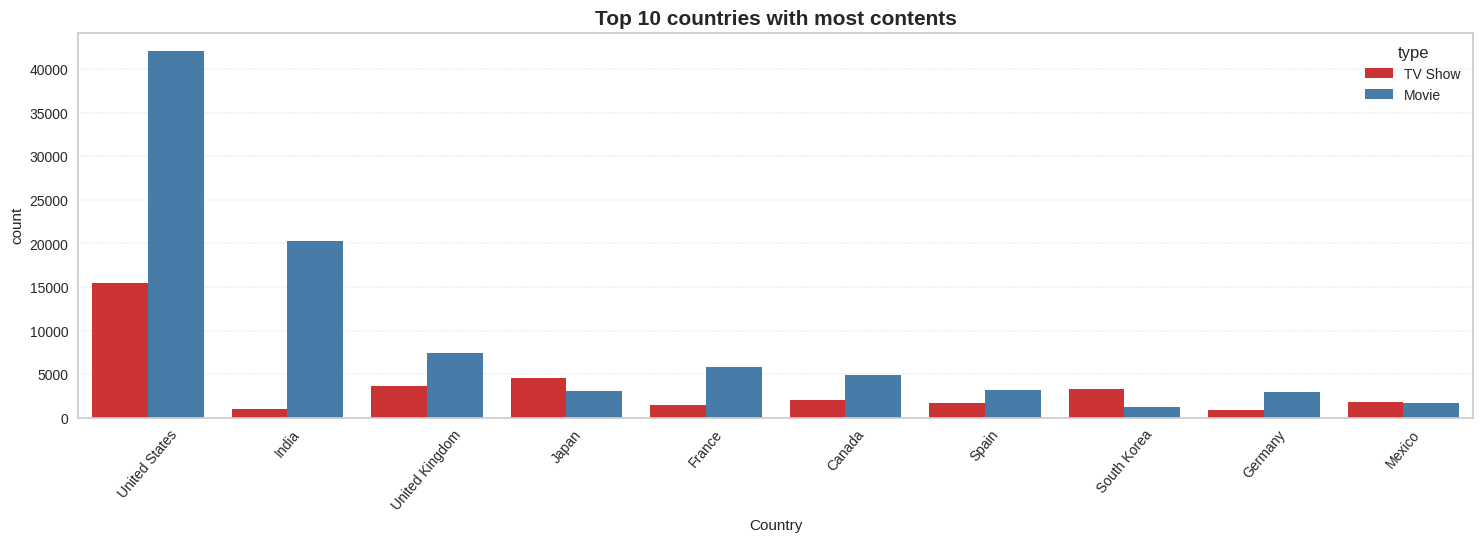

In [32]:
plt.figure(figsize=(18,5))
plt.grid(linestyle='--', linewidth=0.3)
sns.countplot(x=df['Country'],order=df['Country'].value_counts().index[0:10],hue=df['type'],palette ="Set1")
plt.xticks(rotation=50)
plt.title('Top 10 countries with most contents', fontsize=15, fontweight='bold')
plt.show()

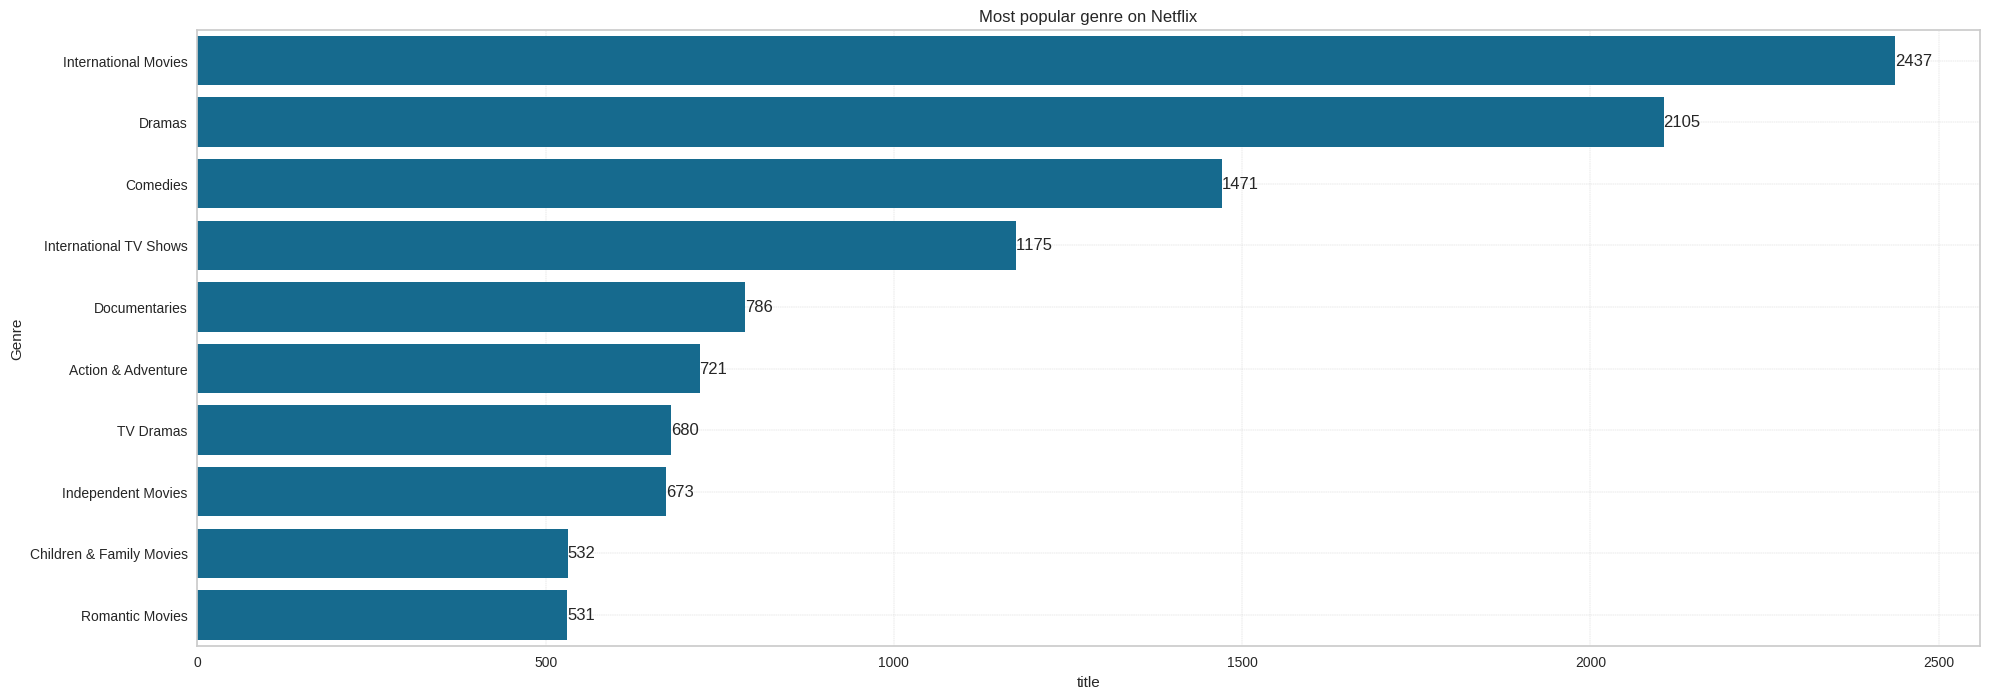

In [33]:
plt.figure(figsize=(23,8))
df_genre = df.groupby(['Genre']).agg({'title':'nunique'}).reset_index().sort_values(by=['title'],ascending=False)[:10]
plots= sns.barplot(y = "Genre",x = 'title', data = df_genre)
plt.title(f'Most popular genre on Netflix')
plt.grid(linestyle='--', linewidth=0.3)
plots.bar_label(plots.containers[0])
plt.show()

shows and movies added per year

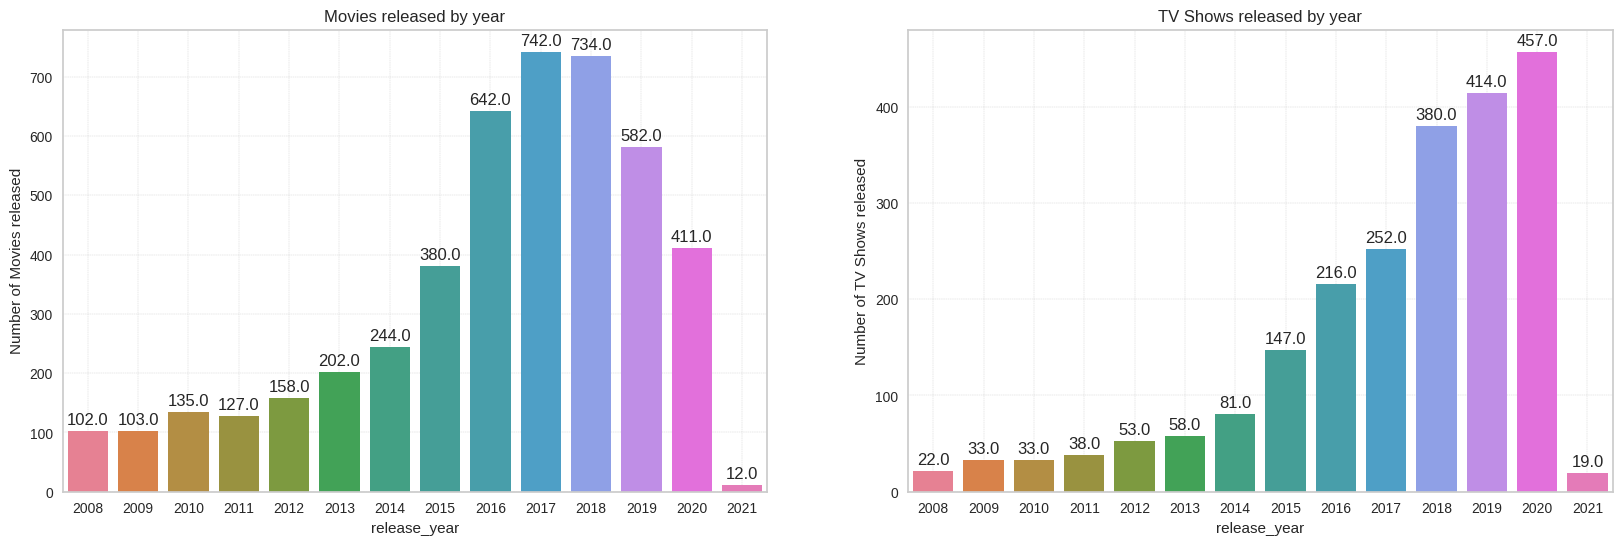

In [34]:
plt.figure(figsize=(20,6))
for i,j,k in ((df_movies, 'Movies',0),(df_tvshows, 'TV Shows',1)):
  plt.subplot(1,2,k+1)
  df_release_year = i.groupby(['release_year']).agg({'title':'nunique'}).reset_index().sort_values(by=['release_year'],ascending=False)[:14]
  plots= sns.barplot(x = 'release_year',y= 'title', data = df_release_year, palette='husl')
  plt.title(f'{j} released by year')
  plt.ylabel(f"Number of {j} released")
  plt.grid(linestyle='--', linewidth=0.3)

  for bar in plots.patches:
     plots.annotate(bar.get_height(),
                    (bar.get_x() + bar.get_width() / 2,
                     bar.get_height()), ha='center', va='center',
                    size=12, xytext=(0, 8),
                    textcoords='offset points')
plt.show()

In [35]:
df.isnull().sum()

title           0
Actors          0
Directors       0
Genre           0
Country         0
type            0
date_added      0
release_year    0
rating          0
duration        0
description     0
dtype: int64

Handeling outliers

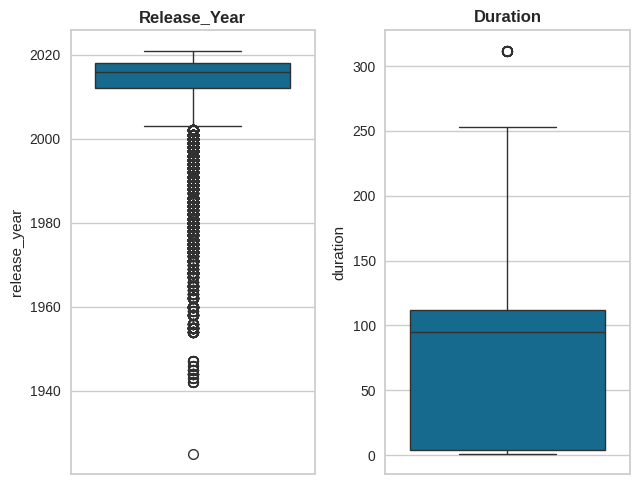

In [36]:
continous_value_feature= ["release_year","duration"]

plt.figure(figsize=(16,5))
for n,column in enumerate(continous_value_feature):
  plt.subplot(1, 5, n+1)
  sns.boxplot(df[column])
  plt.title(f'{column.title()}',weight='bold')
  plt.tight_layout()

In [37]:
df.shape, df_new.shape

((174219, 11), (7770, 12))

In [38]:
df_new['rating'].replace(rating_map, inplace = True)
df_new.sample(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1812,s1813,Movie,Don't Crack Under Pressure,Thierry Donard,"Davide Carrera, Jesse Richman, Loic Collomb-Pa...",France,"June 12, 2020",2015,Adult Content,95 min,"Action & Adventure, Documentaries, Internation...",There are risks. Then there are risk-takers. I...
5762,s5763,Movie,Spitfire: The Plane that Saved the World,"David Fairhead, Anthony Palmer",Charles Dance,United Kingdom,"November 1, 2019",2018,Teen Content,95 min,Documentaries,"In this epic documentary, last-surviving veter..."


In [39]:
df_new["content_detail"]= df_new["cast"]+" "+df_new["director"]+" "+df_new["listed_in"]+" "+df_new["type"]+" "+df_new["rating"]+" "+df_new["country"]+" "+df_new["description"]
df_new.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,content_detail
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,Adult Content,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,"João Miguel, Bianca Comparato, Michel Gomes, R..."
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,Adult Content,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ..."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,Adult Content,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...","Tedd Chan, Stella Chung, Henley Hii, Lawrence ..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,Teen Content,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...","Elijah Wood, John C. Reilly, Jennifer Connelly..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,Teen Content,123 min,Dramas,A brilliant group of students become card-coun...,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar..."


In [40]:
df_new['content_detail']= df_new['content_detail'].str.lower()
df_new.iloc[281,]['content_detail']

'tamannaah bhatia, prabhu deva, sonu sood, sapthagiri, murli sharma, r.v. udhaykumar, joy mathew, hema a. l. vijay comedies, international movies, sci-fi & fantasy movie teen content india due to family pressure, a corporate man reluctantly marries a woman from the village, but in their new home, she abruptly assumes a different persona.'

In [41]:
#removig punctuations
def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [42]:
df_new['content_detail']= df_new['content_detail'].apply(remove_punctuations)
df_new.iloc[281,]['content_detail']

'tamannaah bhatia prabhu deva sonu sood sapthagiri murli sharma rv udhaykumar joy mathew hema a l vijay comedies international movies scifi  fantasy movie teen content india due to family pressure a corporate man reluctantly marries a woman from the village but in their new home she abruptly assumes a different persona'

In [43]:
def remove_url_and_numbers(text):
    url_number_pattern = re.compile(r'https?://\S+|www\.\S+')
    text= re.sub(url_number_pattern,'', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

In [44]:
df_new['content_detail']= df_new['content_detail'].apply(remove_url_and_numbers)
df_new.iloc[281,]['content_detail']

'tamannaah bhatia prabhu deva sonu sood sapthagiri murli sharma rv udhaykumar joy mathew hema a l vijay comedies international movies scifi  fantasy movie teen content india due to family pressure a corporate man reluctantly marries a woman from the village but in their new home she abruptly assumes a different persona'

In [45]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [46]:
def remove_stopwords_and_whitespaces(text):
    text = [word for word in text.split() if not word in stopwords.words('english')]
    text=  " ".join(text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [47]:
df_new['content_detail']= df_new['content_detail'].apply(remove_stopwords_and_whitespaces)
df_new.iloc[281,]['content_detail']

'tamannaah bhatia prabhu deva sonu sood sapthagiri murli sharma rv udhaykumar joy mathew hema l vijay comedies international movies scifi fantasy movie teen content india due family pressure corporate man reluctantly marries woman village new home abruptly assumes different persona'

Tokenization

In [48]:
nltk.download('punkt')

df_new['content_detail']= df_new['content_detail'].apply(nltk.word_tokenize)
df_new.iloc[281,]['content_detail']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['tamannaah',
 'bhatia',
 'prabhu',
 'deva',
 'sonu',
 'sood',
 'sapthagiri',
 'murli',
 'sharma',
 'rv',
 'udhaykumar',
 'joy',
 'mathew',
 'hema',
 'l',
 'vijay',
 'comedies',
 'international',
 'movies',
 'scifi',
 'fantasy',
 'movie',
 'teen',
 'content',
 'india',
 'due',
 'family',
 'pressure',
 'corporate',
 'man',
 'reluctantly',
 'marries',
 'woman',
 'village',
 'new',
 'home',
 'abruptly',
 'assumes',
 'different',
 'persona']

In [49]:
#text normalization
from nltk.stem import WordNetLemmatizer
wordnet  = WordNetLemmatizer()

In [50]:
def lemmatizing_sentence(text):
    text = [wordnet.lemmatize(word) for word in text]
    text=  " ".join(text)
    return text

In [51]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
df_new['content_detail']= df_new['content_detail'].apply(lemmatizing_sentence)
df_new.iloc[281,]['content_detail']

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


'tamannaah bhatia prabhu deva sonu sood sapthagiri murli sharma rv udhaykumar joy mathew hema l vijay comedy international movie scifi fantasy movie teen content india due family pressure corporate man reluctantly marries woman village new home abruptly assumes different persona'

In [52]:
df_new['pos_tags'] = df_new['content_detail'].apply(nltk.word_tokenize).apply(nltk.pos_tag)
df_new.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,content_detail,pos_tags
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,Adult Content,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,jo miguel bianca comparato michel gomes rodolf...,"[(jo, NN), (miguel, NN), (bianca, NN), (compar..."
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,Adult Content,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,demi n bichir h ctor bonilla oscar serrano aza...,"[(demi, NN), (n, CC), (bichir, NN), (h, NN), (..."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,Adult Content,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",tedd chan stella chung henley hii lawrence koh...,"[(tedd, NN), (chan, NN), (stella, NN), (chung,..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,Teen Content,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",elijah wood john c reilly jennifer connelly ch...,"[(elijah, RB), (wood, NN), (john, NN), (c, VBP..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,Teen Content,123 min,Dramas,A brilliant group of students become card-coun...,jim sturgess kevin spacey kate bosworth aaron ...,"[(jim, NN), (sturgess, NN), (kevin, NN), (spac..."


Text vectorization

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(max_features=30000)

In [54]:
x= tfidfv.fit_transform(df_new['content_detail'])
print(x.shape)

(7770, 30000)


dimensionality reduction

In [55]:
from sklearn.decomposition import PCA
import numpy as np

x_small = x[:1000]
pca = PCA()
pca.fit(x_small.toarray())
variance = pca.explained_variance_ratio_
print(f"Explained variance: {variance}")

Explained variance: [1.40602030e-02 5.42415605e-03 4.77596461e-03 4.38639725e-03
 3.81715432e-03 3.45712224e-03 3.34415395e-03 3.11081900e-03
 2.91124932e-03 2.83766226e-03 2.73600118e-03 2.58042657e-03
 2.52725138e-03 2.49665969e-03 2.43653682e-03 2.35089568e-03
 2.33896038e-03 2.31669861e-03 2.23877984e-03 2.23213948e-03
 2.17928792e-03 2.16465588e-03 2.15152994e-03 2.12653686e-03
 2.09196646e-03 2.08274078e-03 2.06097237e-03 2.05020144e-03
 2.02762571e-03 2.01317864e-03 1.99825559e-03 1.97085254e-03
 1.94945956e-03 1.94743236e-03 1.92654112e-03 1.91614312e-03
 1.90441092e-03 1.88899099e-03 1.87856924e-03 1.87473214e-03
 1.86439876e-03 1.84929441e-03 1.83141456e-03 1.82647716e-03
 1.81601261e-03 1.80756501e-03 1.80521413e-03 1.79507708e-03
 1.78278661e-03 1.77817876e-03 1.76460329e-03 1.76152106e-03
 1.75741293e-03 1.75182359e-03 1.73845024e-03 1.73230627e-03
 1.71664554e-03 1.71229441e-03 1.70964797e-03 1.70363702e-03
 1.69311105e-03 1.68633269e-03 1.67158333e-03 1.67017446e-03
 1.6

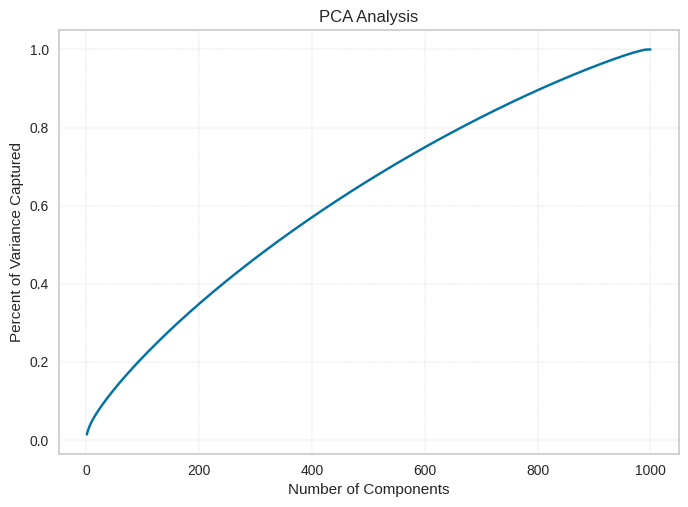

In [56]:
fig, ax = plt.subplots()
ax.plot(range(1, len(variance)+1), np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Number of Components')
ax.set_ylabel('Percent of Variance Captured')
ax.set_title('PCA Analysis')
plt.grid(linestyle='--', linewidth=0.3)
plt.show()

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_new['content_detail'])

cosine_sim = cosine_similarity(tfidf_matrix)

def recommend_content(title, cosine_sim=cosine_sim, data=df_new):
    programme_list = data['title'].to_list()
    index = programme_list.index(title)
    sim_scores = list(enumerate(cosine_sim[index]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    recommend_index = [i[0] for i in sim_scores]
    rec_movie = data['title'].iloc[recommend_index]
    rec_score = [round(i[1], 4) for i in sim_scores]

    rec_table = pd.DataFrame(list(zip(rec_movie, rec_score)), columns=['Recommendation', 'Similarity_score(0-1)'])
    return rec_table

In [58]:
# Testing indian movie
recommend_content('Kal Ho Naa Ho')

,Recommendation,Similarity_score(0-1)
0,Dil Chahta Hai,0.2567
1,Kya Kehna,0.2300
2,My Next Guest with David Letterman and Shah Ru...,0.2048
3,Kuch Kuch Hota Hai,0.1842
4,Together For Eternity,0.1840
5,Kabhi Haan Kabhi Naa,0.1814
6,Chashme Baddoor,0.1776
7,Kabhi Khushi Kabhie Gham,0.1725
8,Kabhi Alvida Naa Kehna,0.1713
9,Chalte Chalte,0.1699


In [59]:
# Testing non indian movie
recommend_content('Zombieland')

,Recommendation,Similarity_score(0-1)
0,30 Minutes or Less,0.1600
1,Kingpin,0.1121
2,No Reservations,0.1113
3,THE RUM DIARY,0.1020
4,Night Moves,0.1013
5,The End of the Tour,0.0925
6,Hush,0.0923
7,The Edge of Seventeen,0.0877
8,Santa Girl,0.0874
9,Kiss the Ground,0.0874


In [60]:
#testibng tv shows
recommend_content('Vampires')

,Recommendation,Similarity_score(0-1)
0,The World Is Yours,0.1429
1,Dinotrux,0.1217
2,Inhuman Resources,0.1194
3,Real Rob,0.1182
4,Dracula,0.1164
5,Balto,0.1149
6,Divines,0.1100
7,My Babysitter's a Vampire,0.1042
8,The Umbrella Academy,0.1037
9,The Originals,0.1019


in conlusion,
churn can be improved by manny ways like a personalizzed recommendation system (to stop the customers by using their preferences of words for recommendations)